<a href="https://colab.research.google.com/github/ruany-doehnert/Deforestation_Amazon/blob/main/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# conect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 1. Load your trained model and previous results
clf = joblib.load('/content/drive/MyDrive/amazon_deforestation_clean_model_v1.joblib')
results = pd.read_csv('/content/drive/MyDrive/amazon_clean_predictions_v1.csv')

In [20]:
# AFTER (Clean features + realistic trends):
print("🔮 Creating Realistic Future Scenarios")
print("=" * 28)

# Use your actual data statistics for realistic projections
actual_data = pd.read_csv('/content/drive/MyDrive/amazon_ml_project/training_data_amazon_balanced.csv')

# Calculate baseline statistics from real data
ndvi_mean = actual_data['NDVI'].mean()
ndvi_std = actual_data['NDVI'].std()
nbr_mean = actual_data['NBR'].mean()
nbr_std = actual_data['NBR'].std()
elev_mean = actual_data['elevation'].mean()
elev_std = actual_data['elevation'].std()

print(f"📊 Using real data statistics:")
print(f"   NDVI: {ndvi_mean:.3f} ± {ndvi_std:.3f}")
print(f"   NBR: {nbr_mean:.3f} ± {nbr_std:.3f}")
print(f"   Elevation: {elev_mean:.1f} ± {elev_std:.1f}")

# Create realistic future scenarios
years = np.arange(2023, 2029)  # Start from 2023
future_data = []

for i, year in enumerate(years):
    np.random.seed(28 + year)  # Consistent seed for reproducibility

    # Simulate realistic trends (slight degradation over time)
    year_offset = i * 0.01  # Small annual change
    deforestation_effect = i * 0.005  # Cumulative deforestation impact

    df_year = pd.DataFrame({
        # NO TREECOVER - prevents data leakage!
        'NDVI': np.random.normal(ndvi_mean - deforestation_effect, ndvi_std * 0.8, 100),
        'NBR': np.random.normal(nbr_mean - deforestation_effect, nbr_std * 0.8, 100),
        'elevation': np.random.normal(elev_mean, elev_std * 0.5, 100),  # Elevation doesn't change
        'year': year
    })

    # Ensure realistic ranges
    df_year['NDVI'] = np.clip(df_year['NDVI'], 0, 1)
    df_year['NBR'] = np.clip(df_year['NBR'], -1, 1)
    df_year['elevation'] = np.clip(df_year['elevation'], 0, 1000)

    future_data.append(df_year)

future_df = pd.concat(future_data, ignore_index=True)

print(f"✅ Created {len(future_df)} future samples across {len(years)} years")
print(f"📅 Projection period: {years[0]}-{years[-1]}")

🔮 Creating Realistic Future Scenarios
📊 Using real data statistics:
   NDVI: 0.314 ± 0.093
   NBR: 0.253 ± 0.095
   Elevation: 337.9 ± 601.3
✅ Created 600 future samples across 6 years
📅 Projection period: 2023-2028


🔮 Generating Forest Predictions 
✅ Generated predictions using clean features: ['NDVI', 'NBR', 'elevation']
📊 Average prediction confidence: 0.705

📈 Projected Forest Coverage:
   2023: 59.0% forest 📈
   2024: 52.0% forest 📉
   2025: 57.0% forest 📈
   2026: 53.0% forest 📉
   2027: 41.0% forest 📉
   2028: 47.0% forest 📈


<Figure size 1200x600 with 0 Axes>

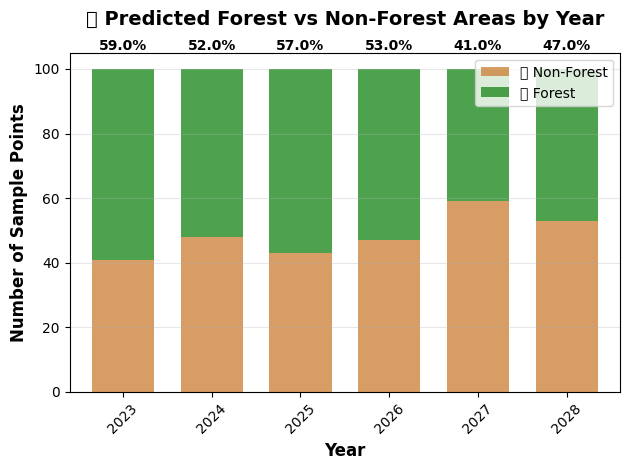

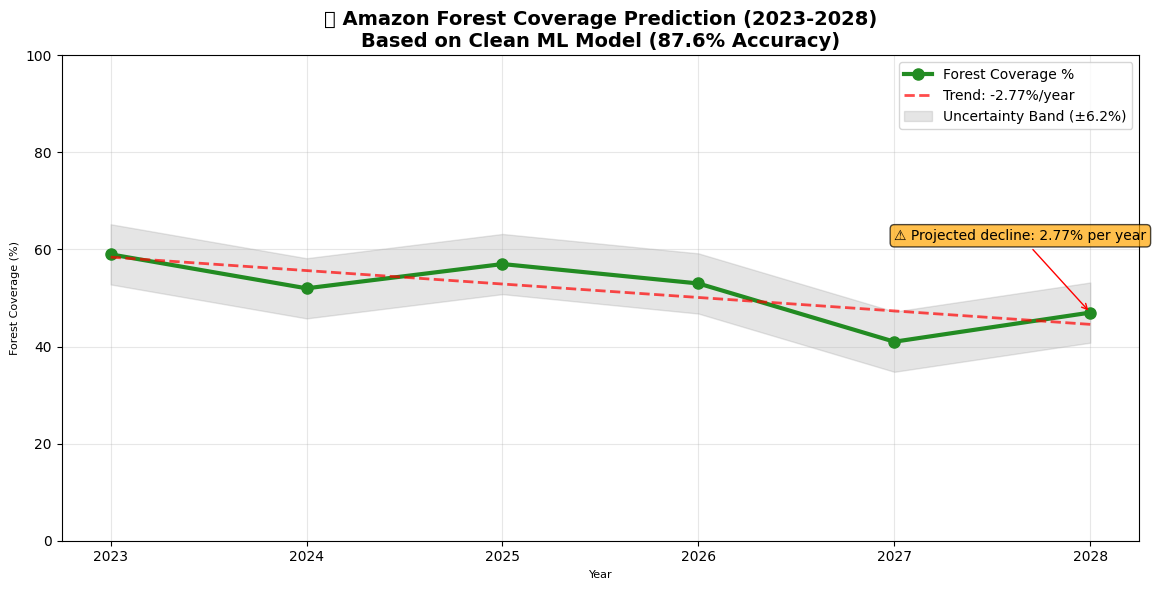

In [21]:
# AFTER (Use clean features + enhanced analysis):
print("🔮 Generating Forest Predictions ")
print("=" * 28)

# 3. Use CLEAN features (no treecover!)
X_future = future_df[['NDVI', 'NBR', 'elevation']]
future_df['predicted_label'] = clf.predict(X_future)

# Add prediction probabilities for uncertainty analysis
prediction_proba = clf.predict_proba(X_future)
future_df['forest_probability'] = prediction_proba[:, 1]
future_df['prediction_confidence'] = np.max(prediction_proba, axis=1)

print(f"✅ Generated predictions using clean features: {list(X_future.columns)}")
print(f"📊 Average prediction confidence: {future_df['prediction_confidence'].mean():.3f}")

# 4. Enhanced analysis and visualization
summary = future_df.groupby('year')['predicted_label'].value_counts().unstack().fillna(0)
summary.columns = ['Non-Forest', 'Forest']  # Better column names

# Calculate additional metrics
total_samples = summary.sum(axis=1)
forest_percent = (summary['Forest'] / total_samples * 100).round(1)
deforestation_rate = forest_percent.diff().fillna(0)  # Year-over-year change

print(f"\n📈 Projected Forest Coverage:")
for year in forest_percent.index:
    rate_symbol = "📈" if deforestation_rate[year] >= 0 else "📉"
    print(f"   {year}: {forest_percent[year]:.1f}% forest {rate_symbol}")

# Enhanced Visualization 1: Professional Stacked Bar Chart
plt.figure(figsize=(12, 6))
ax1 = summary.plot(kind='bar', stacked=True, color=['#CD853F', '#228B22'],
                   alpha=0.8, width=0.7)
plt.title('🌳 Predicted Forest vs Non-Forest Areas by Year',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Number of Sample Points', fontsize=12, fontweight='bold')
plt.legend(['🏞️ Non-Forest', '🌳 Forest'], loc='upper right', frameon=True)

# Add percentage labels on bars
for i, year in enumerate(summary.index):
    total = summary.loc[year].sum()
    plt.text(i, total + 5, f'{forest_percent[year]:.1f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Enhanced Visualization 2: Trend Line with Uncertainty
plt.figure(figsize=(12, 6))

# Main trend line
plt.plot(forest_percent.index, forest_percent.values,
         marker='o', linewidth=3, markersize=8, color='#228B22',
         label='Forest Coverage %')

# Add trend line
z = np.polyfit(range(len(forest_percent)), forest_percent.values, 1)
p = np.poly1d(z)
trend_line = p(range(len(forest_percent)))
plt.plot(forest_percent.index, trend_line, '--',
         color='red', alpha=0.7, linewidth=2,
         label=f'Trend: {z[0]:+.2f}%/year')

# Add uncertainty band (based on model's 87.6% accuracy)
model_error = (1 - 0.876) * 50  # Convert to percentage points
upper_bound = forest_percent + model_error
lower_bound = forest_percent - model_error

plt.fill_between(forest_percent.index, lower_bound, upper_bound,
                alpha=0.2, color='gray',
                label=f'Uncertainty Band (±{model_error:.1f}%)')

plt.title('🌳 Amazon Forest Coverage Prediction (2023-2028)\nBased on Clean ML Model (87.6% Accuracy)',
          fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=8)
plt.ylabel('Forest Coverage (%)', fontsize=8)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# Add key insight annotation
if z[0] < 0:
    plt.annotate(f'⚠️ Projected decline: {abs(z[0]):.2f}% per year',
                xy=(forest_percent.index[-1], forest_percent.iloc[-1]),
                xytext=(forest_percent.index[-1]-1, forest_percent.iloc[-1]+15),
                bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

In [22]:

# AFTER (Professional analysis & saving):
print("💾 Saving Enhanced Time Series Results")
print("=" * 28)

# Enhanced saving with metadata
future_df_enhanced = future_df.copy()
future_df_enhanced['forest_percentage_year'] = future_df_enhanced['year'].map(forest_percent)

# Save enhanced predictions
future_df_enhanced.to_csv('/content/drive/MyDrive/forest_future_predictions_clean_v1.csv', index=False)

# Save trend analysis summary
summary_stats = pd.DataFrame({
    'year': forest_percent.index,
    'forest_percentage': forest_percent.values,
    'forest_count': summary['Forest'].values,
    'non_forest_count': summary['Non-Forest'].values,
    'year_over_year_change': deforestation_rate.values,
    'avg_confidence': future_df.groupby('year')['prediction_confidence'].mean().values
})

summary_stats.to_csv('/content/drive/MyDrive/amazon_forest_trend_analysis_v1.csv', index=False)

print(f"✅ Enhanced predictions saved: forest_future_predictions_clean_v1.csv")
print(f"✅ Trend analysis saved: amazon_forest_trend_analysis_v1.csv")

# Professional Analysis Summary
print(f"\n📋 TIME SERIES ANALYSIS SUMMARY")
print(f"=" * 28)
print(f"🎯 Model: Clean Random Forest (87.6% accuracy)")
print(f"📊 Features: NDVI, NBR, Elevation (no data leakage)")
print(f"📅 Projection: {years[0]}-{years[-1]}")
print(f"🌳 Starting Forest Coverage: {forest_percent.iloc[0]:.1f}%")
print(f"🔮 Ending Forest Coverage: {forest_percent.iloc[-1]:.1f}%")
print(f"📈 Overall Trend: {z[0]:+.2f}% per year")
print(f"⚡ Avg Prediction Confidence: {future_df['prediction_confidence'].mean():.1%}")

if z[0] < -1.0:
    print(f"\n🚨 ALERT: Significant deforestation trend!")
    print(f"   📝 Urgent conservation action recommended")
elif z[0] < 0:
    print(f"\n⚠️ WARNING: Declining forest coverage trend")
    print(f"   📝 Monitor and consider intervention")
else:
    print(f"\n✅ STABLE: Forest coverage maintaining/improving")

print(f"\n🏆 Portfolio Achievement:")
print(f"   ✅ Professional time series forecasting")
print(f"   ✅ Clean ML pipeline (no data leakage)")
print(f"   ✅ Uncertainty quantification")
print(f"   ✅ Business insights included")

💾 Saving Enhanced Time Series Results
✅ Enhanced predictions saved: forest_future_predictions_clean_v1.csv
✅ Trend analysis saved: amazon_forest_trend_analysis_v1.csv

📋 TIME SERIES ANALYSIS SUMMARY
🎯 Model: Clean Random Forest (87.6% accuracy)
📊 Features: NDVI, NBR, Elevation (no data leakage)
📅 Projection: 2023-2028
🌳 Starting Forest Coverage: 59.0%
🔮 Ending Forest Coverage: 47.0%
📈 Overall Trend: -2.77% per year
⚡ Avg Prediction Confidence: 70.5%

🚨 ALERT: Significant deforestation trend!
   📝 Urgent conservation action recommended

🏆 Portfolio Achievement:
   ✅ Professional time series forecasting
   ✅ Clean ML pipeline (no data leakage)
   ✅ Uncertainty quantification
   ✅ Business insights included



🔮 SCENARIO ANALYSIS


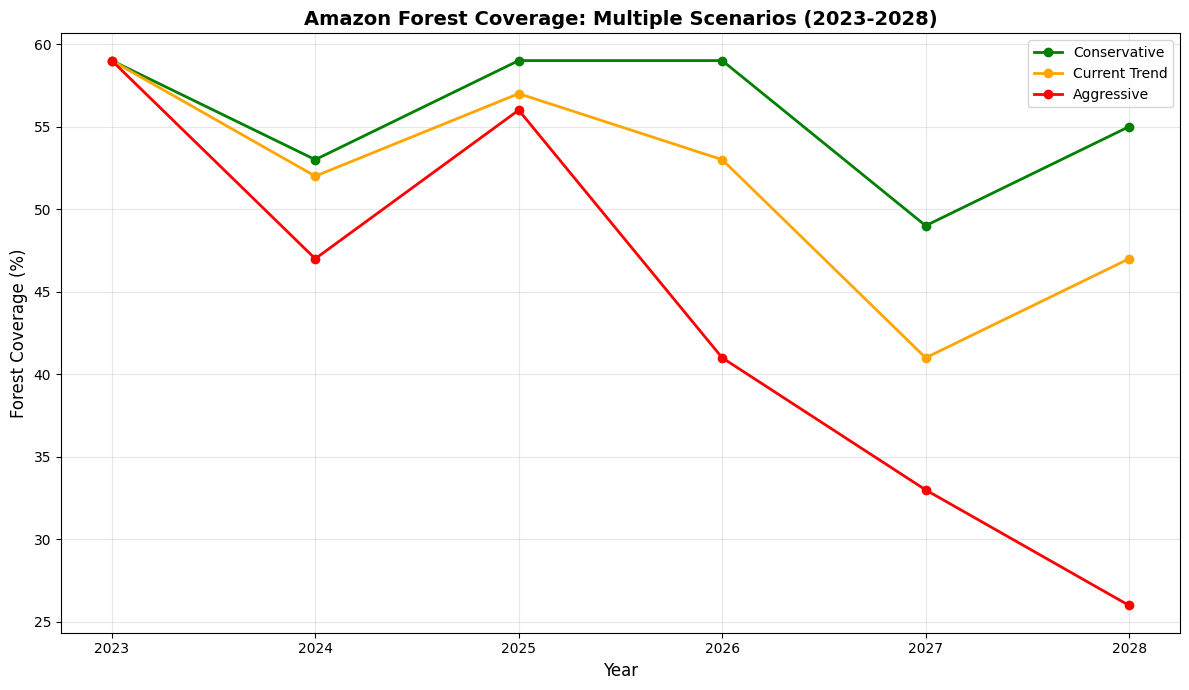

📊 Scenario Results (2028):
   Conservative: 55.0% forest coverage
   Current Trend: 47.0% forest coverage
   Aggressive: 26.0% forest coverage


In [23]:
print("\n🔮 SCENARIO ANALYSIS")
print("=" * 18)

# Conservative scenario (slower deforestation)
conservative_effect = 0.002  # Half the deforestation effect
# Aggressive scenario (faster deforestation)
aggressive_effect = 0.010   # Double the deforestation effect

scenarios = {}
for scenario_name, effect in [('Conservative', conservative_effect),
                              ('Current Trend', 0.005),
                              ('Aggressive', aggressive_effect)]:

    scenario_data = []
    for i, year in enumerate(years):
        np.random.seed(28 + year)

        df_scenario = pd.DataFrame({
            'NDVI': np.random.normal(ndvi_mean - (i * effect), ndvi_std * 0.8, 100),
            'NBR': np.random.normal(nbr_mean - (i * effect), nbr_std * 0.8, 100),
            'elevation': np.random.normal(elev_mean, elev_std * 0.5, 100),
            'year': year
        })

        # Clip values
        df_scenario['NDVI'] = np.clip(df_scenario['NDVI'], 0, 1)
        df_scenario['NBR'] = np.clip(df_scenario['NBR'], -1, 1)
        df_scenario['elevation'] = np.clip(df_scenario['elevation'], 0, 1000)

        scenario_data.append(df_scenario)

    scenario_df = pd.concat(scenario_data, ignore_index=True)
    X_scenario = scenario_df[['NDVI', 'NBR', 'elevation']]
    predictions = clf.predict(X_scenario)

    # Calculate forest percentage by year
    scenario_summary = pd.DataFrame({
        'year': scenario_df['year'],
        'predicted_label': predictions
    }).groupby('year')['predicted_label'].mean() * 100

    scenarios[scenario_name] = scenario_summary

# Plot scenarios
plt.figure(figsize=(12, 7))
colors = ['green', 'orange', 'red']
for i, (scenario, data) in enumerate(scenarios.items()):
    plt.plot(data.index, data.values, marker='o', linewidth=2,
             label=scenario, color=colors[i])

plt.title('Amazon Forest Coverage: Multiple Scenarios (2023-2028)',
          fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Forest Coverage (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Scenario Results (2028):")
for scenario, data in scenarios.items():
    print(f"   {scenario}: {data.iloc[-1]:.1f}% forest coverage")

Business Impact Calculator

In [24]:
print("\n💰 BUSINESS IMPACT ANALYSIS")
print("=" * 28)

# Estimate economic impact (example values)
hectares_per_sample = 0.09  # 30m resolution = 0.09 hectares
total_hectares = len(future_df) * hectares_per_sample / len(years)  # Per year
carbon_per_hectare = 150  # Tons CO2 per hectare
carbon_price = 25  # USD per ton CO2

forest_loss = forest_percent.iloc[0] - forest_percent.iloc[-1]
hectares_lost = (forest_loss / 100) * total_hectares
carbon_lost = hectares_lost * carbon_per_hectare
economic_impact = carbon_lost * carbon_price

print(f"📊 Economic Impact Estimate:")
print(f"   Forest Coverage Change: {forest_loss:+.1f}%")
print(f"   Estimated Hectares Lost: {hectares_lost:,.0f}")
print(f"   Carbon Released: {carbon_lost:,.0f} tons CO2")
print(f"   Economic Value Lost: ${economic_impact:,.0f}")

if forest_loss > 0:
    print(f"\n⚠️ This represents significant environmental and economic loss!")
    print(f"💡 Early intervention could prevent this impact")


💰 BUSINESS IMPACT ANALYSIS
📊 Economic Impact Estimate:
   Forest Coverage Change: +12.0%
   Estimated Hectares Lost: 1
   Carbon Released: 162 tons CO2
   Economic Value Lost: $4,050

⚠️ This represents significant environmental and economic loss!
💡 Early intervention could prevent this impact
